In [1]:
# Libraries import 
import pdbufr
import sys
import traceback
 
from math import isnan
from eccodes import *
from ecmwf.opendata import Client
from datetime import datetime, timedelta
from PIL import Image

import os
import birdy
import geopandas as gpd
import pandas as pd
import numpy as np
import xarray as xr
import requests

from ipywidgets import interact
import ipyleaflet
import ipywidgets as widgets

from Magics import macro as magics
from IPython.display import display
from Magics.macro import *

import warnings
warnings.filterwarnings("ignore")

from tracks_utils import *

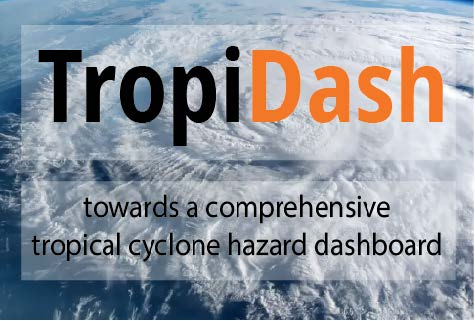

In [2]:
title_img = Image.open('layout_data/title.jpg')
display(title_img)

In [3]:
## WIDGET TO DEFINE THE STARTING DATE OF THE FORECAST ##
## This sets the date of which we want to download the forecast ##

start_date_forecast = widgets.DatePicker(
    description = 'Forecast date:',
    value = datetime(datetime.now().year, datetime.now().month, datetime.now().day, hour=0),
)

start_date_forecast.style.description_width = '90px'

# Print widget
display(start_date_forecast)

DatePicker(value=datetime.datetime(2023, 8, 28, 0, 0), description='Forecast date:', step=1, style=Description…

In [4]:
## DOWNLOAD THE FORECAST TRACKS ##
# The forecast data is saved as bufr file called tc_test_track_data.bufr    
download_tracks_forecast(start_date_forecast.value)

## DOWNLOAD THE OBSERVED TRACKS DATA FROM IBTrACS ##
# The observed data is saved as a csv file called ibtracs.ACTIVE.list.v04r00.csv
url = 'https://www.ncei.noaa.gov/data/international-best-track-archive-for-climate-stewardship-ibtracs/v04r00/access/csv/ibtracs.ACTIVE.list.v04r00.csv'
r = requests.get(url, allow_redirects=True)
save_file = 'data/ibtracs.ACTIVE.list.v04r00.csv'
with open(save_file, 'wb') as f:
    f.write(r.content)

20230828000000-240h-enfo-tf.bufr:   0%|          | 0.00/876k [00:00<?, ?B/s]

In [5]:
## LOAD THE FORECAST DATA OF THE TRACKS IN A DATAFRAME ##
# create_storms_df loads a file called tc_test_track_data.bufr
df_storms_forecast = create_storms_df()

## LOAD THE OBSERVED TRACKS IN A DATAFRAME ## 
df_storms_observed = pd.read_csv('data/ibtracs.ACTIVE.list.v04r00.csv', header=[0,1])

## FIND THE CORRESPONDING CYCLONES BETWEEN FORECAST AND OBSERVATIONS ## 
storms_pair = storms_pairing(df_storms_forecast, df_storms_observed)

In [6]:
datetime.strptime(df_storms_observed.ISO_TIME.squeeze()[0], "%Y-%m-%d %H:%M:%S")

datetime.datetime(2023, 8, 13, 18, 0)

In [7]:
df_storms_observed.ISO_TIME.squeeze()[0]

'2023-08-13 18:00:00'

In [8]:
## WIDGET TO SHOW THE LIST OF ACTIVE CYCLONES AND SELECT THE ONE OF WHICH WE WANT TO PLOT THE DATA ##

cyclone = widgets.Dropdown(
    options = storms_pair,
    description = 'Active Storms:',
    disabled=False,
)
cyclone.style.description_width = '90px'

# Update storms list when downloading new tracks data
def update_storms_list(_):
    download_tracks_forecast(start_date_forecast.value)
    df_storms_forecast = create_storms_df()
    df_storms_observed = pd.read_csv('data/ibtracs.ACTIVE.list.v04r00.csv', header=[0,1])
    storms_pair = storms_pairing(df_storms_forecast, df_storms_observed)
    cyclone.options = storms_pair

start_date_forecast.observe(update_storms_list, names='value')

# Print widget
display(cyclone)

Dropdown(description='Active Storms:', options=('08L-FRANKLIN', '10E-HAROLD', '10L-NOT_NAMED'), style=Descript…

In [9]:
## UPDATE BUTTON TO PLOT NEW TRACKS DATA DEPENDING ON THE CYCLONE SELECTED ##

update_button = widgets.Button(
    description = 'Update Forecast',
    style=dict(
        button_color='blue',
        font_weight='bold',
        text_color='lightgreen',
        text_decoration='underline',
))

update_output = widgets.Output()

# Plot new data when clicking the Update Forecast Button
def on_button_clicked(b):
    with update_output:
        print("Producing new cyclone tracks plot")
        tc_track_map = plot_cyclone_tracks_ipyleaflet(cyclone.value)
        display(tc_track_map)
        # Output of initial lat-lon, average track and initial-final time step of the cyclone for the next sections
        code, name = cyclone.value.split('-')
        df_storms_forecast = create_storms_df()
        df_storms_observed = pd.read_csv('data/ibtracs.ACTIVE.list.v04r00.csv', header=[0,1])
        df_f = df_storms_forecast[df_storms_forecast.stormIdentifier == code]
        df_f.reset_index(drop=True, inplace=True)
        df_o = df_storms_observed[df_storms_observed.NAME.squeeze() == name]
        df_o.reset_index(drop=True, inplace=True)
        # Initial lat-lon
        initial_lat_lon = (df_f.latitude.iloc[0], df_f.longitude.iloc[0])
        # Average track
        locations_avg, radii_avg, timesteps_avg = mean_forecast_track(df_f)
        # Initial and final time step
        df_f["date"] = datetime(df_f.year[0], df_f.month[0], df_f.day[0], df_f.hour[0]) + timedelta(hours=1) * df_f.timePeriod
        initial_timestep = datetime.strptime(df_o.ISO_TIME.squeeze()[0], "%Y-%m-%d %H:%M:%S")
        final_timestep = df_f.date.iloc[-1].to_pydatetime()
        
        # print("Forecast updated!", end='\r')

update_button.on_click(on_button_clicked)

# Print widget
display(update_button, update_output)

Button(description='Update Forecast', style=ButtonStyle(button_color='blue', font_weight='bold', text_color='l…

Output()

In [10]:
'''tc_track_map = plot_cyclone_tracks_ipyleaflet(cyclone.value)
grid = widgets.GridspecLayout(4,3)

#grid[0,0] = title_img
grid[1,0] = start_date_forecast
grid[2,0] = cyclone
grid[3,0] = update_button

grid[:,1:] = tc_track_map

#grid[1,:].laout.height = 'auto'
grid'''

"tc_track_map = plot_cyclone_tracks_ipyleaflet(cyclone.value)\ngrid = widgets.GridspecLayout(4,3)\n\n#grid[0,0] = title_img\ngrid[1,0] = start_date_forecast\ngrid[2,0] = cyclone\ngrid[3,0] = update_button\n\ngrid[:,1:] = tc_track_map\n\n#grid[1,:].laout.height = 'auto'\ngrid"